In [1]:
import torch
import torchquantum as tq
from MSA.tqm_fix import qiskit2tq_op_history, VQE
from MSA.utils import MSAINFO, getHamiltonianDiag, draw_from_dict
from qiskit import QuantumCircuit, Aer
from qiskit.circuit import ParameterVector
import numpy as np
from torchquantum.plugin import tq2qiskit
from MSA.utils import unparameterized2parameterized


## Initialization

In [2]:
seqs = ['AG', 'G']
# seqs = ['ACG', 'AG', 'A']
# seqs = ['ACGG', 'AGG', 'AT']
# seqs = ['ACGG', 'AG', 'AT', 'C']
# seqs = ['ACGGT', 'AGG', 'AT', 'CT']

In [3]:
msa = MSAINFO(seqs, p=1)

## Get Hamiltonian

In [4]:
H = torch.tensor(getHamiltonianDiag(msa), dtype=torch.complex64)

### get Paulis Decomposition (if use the VQE in torchquantum.algorithm)

In [5]:
from MSA.hamiltonian import Hamiltonian2PauliString
from MSA.tqm_fix import Hamiltonian
import os, pickle

In [6]:
if os.path.exists(f'./Hamiltonian/PaulisDecom{msa.encoding_dims}.pkl'):
    with open(f'./Hamiltonian/PaulisDecom{msa.encoding_dims}.pkl', 'rb') as f:
        paulis_operators = pickle.load(f)
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    H2P = Hamiltonian2PauliString()
    h2p = H2P.to(device)

    H = torch.tensor(getHamiltonianDiag(msa))
    H = H.to(device)

    paulis_operators = h2p(H)
    with open(f'./Hamiltonian/PaulisDecom{msa.encoding_dims}.pkl', 'wb') as f:
        pickle.dump(paulis_operators, f)

hamil = Hamiltonian(list(paulis_operators.values()), list(paulis_operators.keys()))

## Construct Ansatz

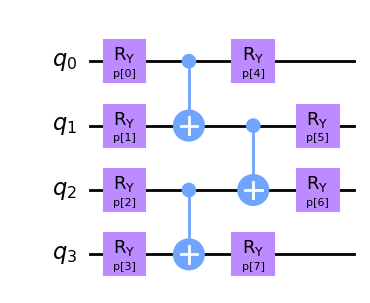

In [7]:
n_layers = 1
n_qubits = msa.encoding_dims
circ = QuantumCircuit(n_qubits)
pv = ParameterVector("p", (n_layers + 1) * n_qubits)
for i in range(n_qubits):
    circ.ry(pv[i], i)
for j in range(n_layers):
    for i in range(n_qubits // 2):
        circ.cnot(2*i, 2*i+1)
    if n_qubits % 2 == 0:
        for i in range(n_qubits // 2-1):
            circ.cnot(2*i+1, 2*i+2)
    else:
        for i in range(n_qubits // 2):
            circ.cnot(2*i+1, 2*i+2)
    for i in range(n_qubits):
        circ.ry(pv[(j+1)*n_qubits + i], i)
circ.draw()

In [8]:
circ = circ.bind_parameters(np.random.random(circ.num_parameters))
ops = qiskit2tq_op_history(circ)
ansatz = tq.QuantumModule.from_op_history(ops)
ansatz.n_wires = circ.num_qubits

## VQE

In [9]:
configs = {
    "n_epochs": 5,
    "n_steps": 10,
    "optimizer": "Adam",
    "scheduler": "CosineAnnealingLR",
    "lr": 0.5,
    "device": "cuda",
}

In [10]:
vqe = VQE(
    hamil=H,
    ansatz=ansatz,
    train_configs=configs,
)

In [11]:
vqe.train()

Epoch: 0, Step: 0, Loss: 3.8093090057373047
Epoch: 0, Step: 1, Loss: 2.0247716903686523
Epoch: 0, Step: 2, Loss: 1.2668218612670898
Epoch: 0, Step: 3, Loss: 1.1423637866973877
Epoch: 0, Step: 4, Loss: 1.1532971858978271
Epoch: 0, Step: 5, Loss: 1.1711657047271729
Epoch: 0, Step: 6, Loss: 1.1580960750579834
Epoch: 0, Step: 7, Loss: 1.114060878753662
Epoch: 0, Step: 8, Loss: 1.0629359483718872
Epoch: 0, Step: 9, Loss: 1.0545557737350464
Epoch: 1, Step: 0, Loss: 1.0898208618164062
Epoch: 1, Step: 1, Loss: 1.122305154800415
Epoch: 1, Step: 2, Loss: 1.1408849954605103
Epoch: 1, Step: 3, Loss: 1.141893982887268
Epoch: 1, Step: 4, Loss: 1.1154505014419556
Epoch: 1, Step: 5, Loss: 1.0505256652832031
Epoch: 1, Step: 6, Loss: 0.921856164932251
Epoch: 1, Step: 7, Loss: 0.6591113805770874
Epoch: 1, Step: 8, Loss: 0.18712520599365234
Epoch: 1, Step: 9, Loss: -0.3904964029788971
Epoch: 2, Step: 0, Loss: -0.7214018106460571
Epoch: 2, Step: 1, Loss: -0.7619173526763916
Epoch: 2, Step: 2, Loss: -0.7930

-0.9978249669075012

## Visualization

In [12]:
optimal_circuit = tq2qiskit(tq.QuantumDevice(n_wires=msa.encoding_dims), ansatz, draw=False)
# circ_structure, optimal_params = unparameterized2parameterized(optimal_circuit, name='theta')
optimal_circuit.measure_all()

In [13]:
backend = Aer.get_backend('qasm_simulator')
res = backend.run(optimal_circuit.decompose(reps=3), shots=5000).result()
counts = res.get_counts()
counts

{'1011': 4991, '1101': 3, '1010': 4, '0011': 1, '1111': 1}

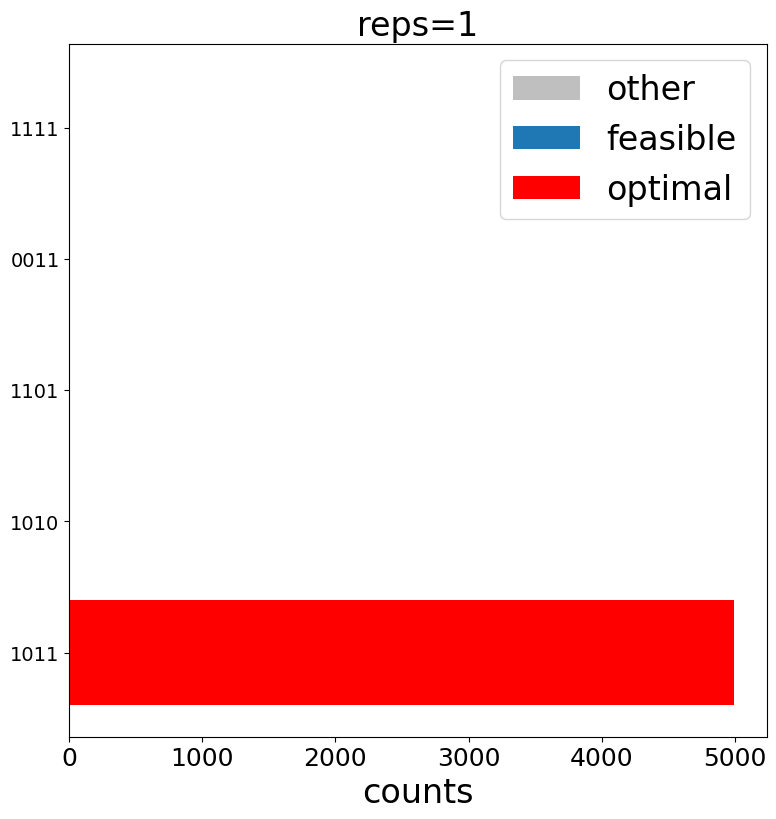

In [14]:
draw_from_dict(counts, ideal_state=['1101'[::-1]], feasible_state=['1110'[::-1]], reps=1, is_save=False, heng=1)